### 1. SETUP

In [8]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from functools import partial
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_sample_image


# ===== SETUP SECTION =====
print("=== SETUP ===")

# Cek versi Python (≥3.5)
assert sys.version_info >= (3, 5), "Python 3.5+ diperlukan"

# Cek TensorFlow (≥2.0)
assert tf.__version__ >= "2.0", "TensorFlow 2.0+ diperlukan"

print(f"TensorFlow version: {tf.__version__}")

# Cek GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU terdeteksi: {len(gpus)} GPU")
    # Konfigurasi memory growth untuk GPU
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting GPU memory growth: {e}")
else:
    print("Tidak ada GPU yang terdeteksi. CNN akan berjalan lebih lambat tanpa GPU.")

# Set random seeds untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Konfigurasi matplotlib untuk plotting
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Fungsi untuk menyimpan gambar (opsional)
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """Menyimpan figure matplotlib ke file"""
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print(f"Menyimpan gambar: {fig_id}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Utility functions untuk plotting
def plot_image(image):
    """Plot gambar grayscale"""
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    """Plot gambar berwarna"""
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

=== SETUP ===
TensorFlow version: 2.18.0
GPU terdeteksi: 1 GPU


### 2. APA ITU KONVOLUSI?

Shape gambar: (2, 427, 640, 3)
Output shape setelah convolution: (2, 427, 640, 2)


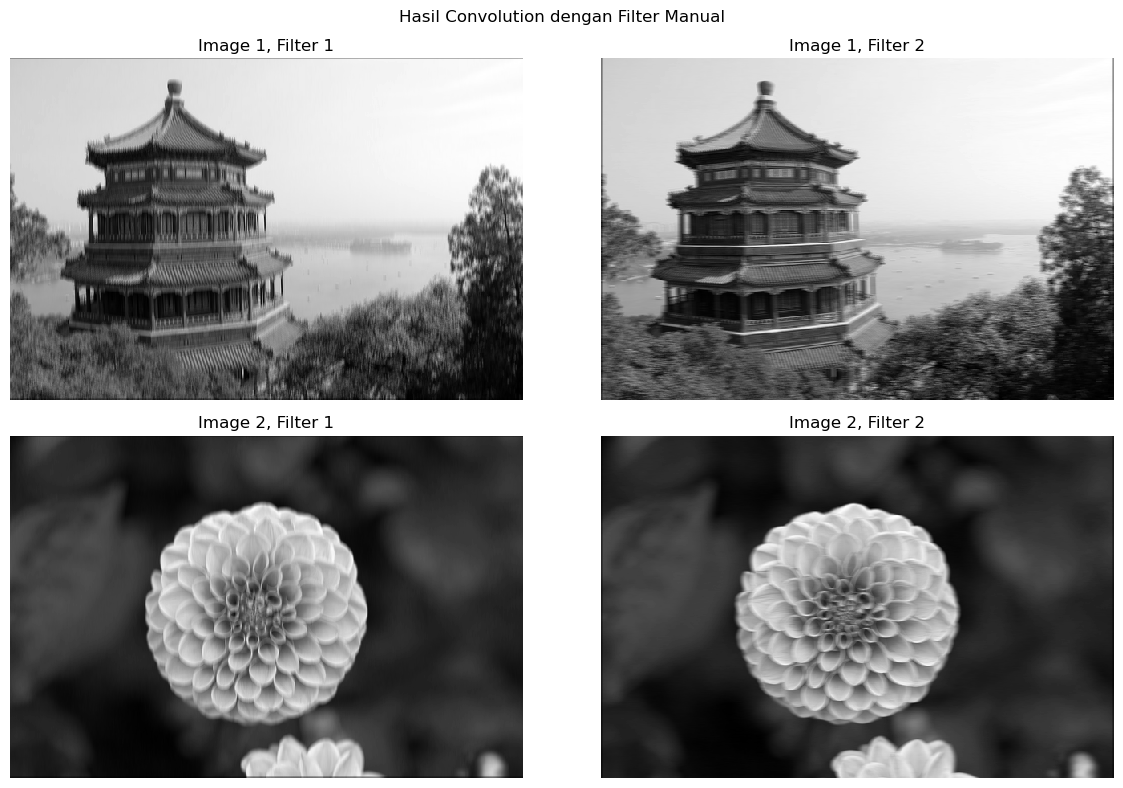

In [9]:
# Load sample images
try:
    china = load_sample_image("china.jpg") / 255.0
    flower = load_sample_image("flower.jpg") / 255.0
    images = np.array([china, flower])
    batch_size, height, width, channels = images.shape
    print(f"Shape gambar: {images.shape}")
    
    # Buat 2 filter manual (vertical dan horizontal line detector)
    filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
    filters[:, 3, :, 0] = 1  # vertical line filter
    filters[3, :, :, 1] = 1  # horizontal line filter
    
    # Aplikasikan convolution
    outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
    print(f"Output shape setelah convolution: {outputs.shape}")
    
    # Visualisasi hasil
    plt.figure(figsize=(12, 8))
    for image_index in (0, 1):
        for feature_map_index in (0, 1):
            plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
            plot_image(outputs[image_index, :, :, feature_map_index])
            plt.title(f"Image {image_index+1}, Filter {feature_map_index+1}")
    
    plt.suptitle("Hasil Convolution dengan Filter Manual")
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error loading sample images: {e}")
    print("Melanjutkan dengan data sintetis...")
    # Buat data sintetis jika sample images tidak tersedia
    images = np.random.rand(2, 100, 100, 3).astype(np.float32)
    
def plot_color_image(image):
    plt.imshow(image)
    plt.axis("off")

### 3. LAYER KONVOLUSIONAL (KERAS)

In [10]:
# Buat Conv2D layer menggunakan Keras
conv_layer = keras.layers.Conv2D(
    filters=2, 
    kernel_size=7, 
    strides=1,
    padding="SAME", 
    activation="relu"
)

# Build layer dengan input shape yang sesuai
conv_layer.build(input_shape=(None, *images.shape[1:]))

print(f"Conv layer weights shape: {[w.shape for w in conv_layer.weights]}")

# Aplikasikan layer ke images
conv_outputs = conv_layer(images)
print(f"Conv layer output shape: {conv_outputs.shape}")

Conv layer weights shape: [TensorShape([7, 7, 3, 2]), TensorShape([2])]
Conv layer output shape: (2, 427, 640, 2)


### 4. PADDING 'VALID' VS 'SAME'

In [11]:
def manual_same_padding(images, kernel_size, strides=1):
    batch_size, height, width, channels = images.shape
    # Menghitung ukuran feature map output dengan padding 'SAME'
    fmap_height = (height - 1) // strides + 1
    fmap_width = (width - 1) // strides + 1
    # Menghitung ukuran gambar yang dibutuhkan setelah di-padding
    padded_height = max((fmap_height - 1) * strides + kernel_size, height)
    padded_width = max((fmap_width - 1) * strides + kernel_size, width)
    # Menghitung jumlah padding di setiap sisi
    pad_top = (padded_height - height) // 2
    pad_left = (padded_width - width) // 2
    # Membuat tensor kosong dan mengisi dengan gambar di tengahnya
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, pad_top:height+pad_top, pad_left:width+pad_left, :] = images
    return padded_images

kernel_size = 7
strides = 2

# Layer dengan padding 'VALID' akan diaplikasikan pada gambar yang sudah di-padding manual
conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Layer dengan padding 'SAME' diaplikasikan pada gambar asli
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")
conv_same.build(tf.TensorShape(images.shape)) # build() untuk membuat bobot
conv_same.set_weights(conv_valid.get_weights()) # Salin bobot agar perbandingan adil
same_output = conv_same(images.astype(np.float32))

# Membandingkan hasil kedua pendekatan
print(f"Bentuk output 'VALID' dengan padding manual: {valid_output.shape}")
print(f"Bentuk output 'SAME' otomatis: {same_output.shape}")
print(f"Apakah output keduanya sama? {np.allclose(valid_output.numpy(), same_output.numpy())}")

Bentuk output 'VALID' dengan padding manual: (2, 214, 320, 1)
Bentuk output 'SAME' otomatis: (2, 214, 320, 1)
Apakah output keduanya sama? True


### 5. LAYER POOLING

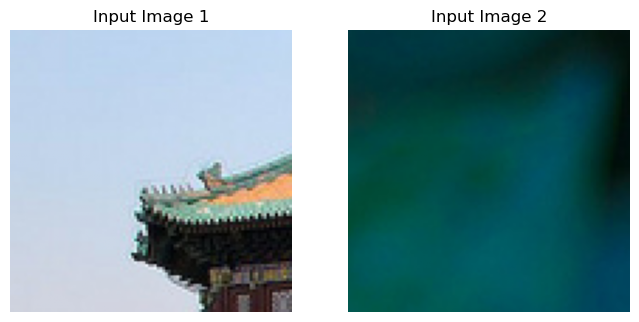

In [12]:
# Crop images untuk demonstrasi yang lebih jelas
def crop(images, start_h=50, end_h=150, start_w=50, end_w=150):
    """Crop images untuk fokus pada area tertentu"""
    return images[:, start_h:end_h, start_w:end_w, :]

if images.shape[1] > 100 and images.shape[2] > 100:
    cropped_images = crop(images)
else:
    cropped_images = images

plt.figure(figsize=(8, 4))
for i in range(cropped_images.shape[0]):
      plt.subplot(1, 2, i + 1)
      plot_color_image(cropped_images[i])
      plt.title(f"Input Image {i + 1}")

Input shape: (2, 100, 100, 3)
Max pool output shape: (2, 50, 50, 3)


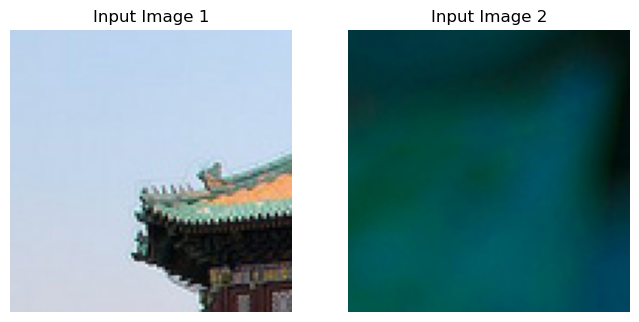

In [13]:
# Max Pooling
max_pool = keras.layers.MaxPool2D(pool_size=2)

# Crop images untuk demonstrasi yang lebih jelas
def crop(images, start_h=50, end_h=150, start_w=50, end_w=150):
    """Crop images untuk fokus pada area tertentu"""
    return images[:, start_h:end_h, start_w:end_w, :]

if images.shape[1] > 100 and images.shape[2] > 100:
    cropped_images = crop(images)
else:
    cropped_images = images

cropped_images = tf.cast(cropped_images, tf.float32)
max_pool_output = max_pool(cropped_images)

print(f"Input shape: {cropped_images.shape}")
print(f"Max pool output shape: {max_pool_output.shape}")
# Visualisasi hasil Max Pooling
plt.figure(figsize=(8, 4))
for i in range(cropped_images.shape[0]):
      plt.subplot(1, 2, i + 1)
      plot_color_image(cropped_images[i])
      plt.title(f"Input Image {i + 1}")
      

Average pool output shape: (2, 50, 50, 3)


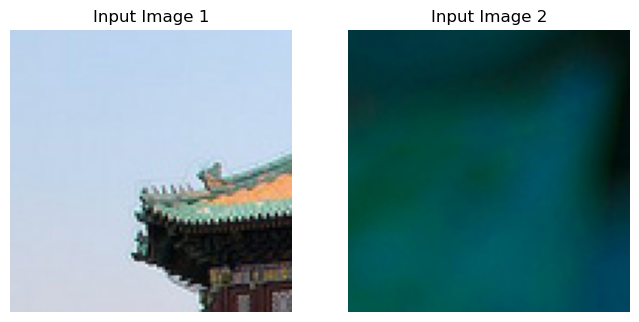

In [14]:
# Average Pooling
avg_pool = keras.layers.AvgPool2D(pool_size=2)
avg_pool_output = avg_pool(cropped_images)
print(f"Average pool output shape: {avg_pool_output.shape}")
# Visualisasi hasil Average Pooling
plt.figure(figsize=(8, 4))
for i in range(cropped_images.shape[0]):
      plt.subplot(1, 2, i + 1)
      plot_color_image(cropped_images[i])
      plt.title(f"Input Image {i + 1}")

Global average pool output shape: (2, 3)


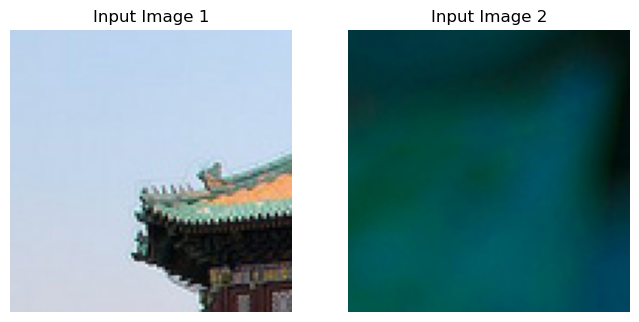

In [15]:
# Global Average Pooling
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_output = global_avg_pool(cropped_images)
print(f"Global average pool output shape: {global_avg_output.shape}")
# Visualisasi hasil Global Average Pooling
plt.figure(figsize=(8, 4))
for i in range(cropped_images.shape[0]):
      plt.subplot(1, 2, i + 1)
      plot_color_image(cropped_images[i])
      plt.title(f"Input Image {i + 1}")

In [16]:
# --- Global Average Pooling ---
# Menghitung rata-rata dari seluruh feature map, menghasilkan satu nilai per feature map.
# Berguna untuk layer output pada model klasifikasi.
global_avg_pool = keras.layers.GlobalAvgPool2D()
output_global_avg = global_avg_pool(cropped_images)
print(f"Bentuk output setelah GlobalAvgPool2D: {output_global_avg.shape}")

Bentuk output setelah GlobalAvgPool2D: (2, 3)


### 6. MEMBANGUN CNN UNTUK KLASIFIKASI FASHION MNIST

In [17]:
# Load dan preprocess Fashion MNIST data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Split data
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [18]:
# Normalisasi data
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

In [19]:
# Tambah dimensi channel (grayscale = 1 channel)
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_valid.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (55000, 28, 28, 1)
Validation data shape: (5000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


In [20]:
# Buat CNN model untuk Fashion MNIST
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

fashion_model = keras.models.Sequential([
    DefaultConv2D(filters=32, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

/home/ardi/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Compile model
fashion_model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer="adam",  # Gunakan adam untuk konvergensi yang lebih stabil
    metrics=["accuracy"]
)

In [22]:
print("Fashion MNIST CNN Model Summary:")
fashion_model.summary()

Fashion MNIST CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 434,954 (1.66 MB)

 Trainable params: 434,954 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Training dengan epoch yang dikurangi untuk demo
print("Training Fashion MNIST CNN (epochs dikurangi untuk demo)...")
history = fashion_model.fit(
    X_train, y_train, 
    epochs=3,  # Dikurangi dari 10 untuk demo
    validation_data=(X_valid, y_valid),
    batch_size=128,
    verbose=1
)

Training Fashion MNIST CNN (epochs dikurangi untuk demo)...
Epoch 1/3


I0000 00:00:1750436754.290738  262279 service.cc:148] XLA service 0x7f0a50002c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750436754.290840  262279 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-06-20 23:25:54.334690: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-20 23:25:55.390278: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[128,64,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,32,14,14]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_

  6/430 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.1383 - loss: 2.2908 

I0000 00:00:1750436758.875373  262279 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


428/430 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5594 - loss: 1.2067

2025-06-20 23:26:03.970044: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[88,64,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[88,32,14,14]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-20 23:26:04.031457: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[88,64,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[88,64,14,14]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5600 - loss: 1.2051

2025-06-20 23:26:07.898620: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[128,64,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,32,14,14]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-20 23:26:08.009406: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[128,64,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,14,14]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActiv

430/430 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.5603 - loss: 1.2043 - val_accuracy: 0.8424 - val_loss: 0.4351
Epoch 2/3
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8250 - loss: 0.5231 - val_accuracy: 0.8748 - val_loss: 0.3659
Epoch 3/3
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8664 - loss: 0.4105 - val_accuracy: 0.8918 - val_loss: 0.3176


In [24]:
# Evaluasi model
test_loss, test_accuracy = fashion_model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

2025-06-20 23:26:23.541362: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,14,14]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-20 23:26:23.603285: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,14,14]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

Test accuracy: 0.8844


In [25]:
# Prediksi pada beberapa gambar baru
X_new = X_test[:10]
y_pred_proba = fashion_model.predict(X_new)
y_pred = np.argmax(y_pred_proba, axis=1)

print("\nContoh prediksi untuk 10 gambar pertama dari test set:")
print(f"Label sebenarnya : {y_test[:10]}")
print(f"Label prediksi   : {y_pred}")

2025-06-20 23:26:27.623188: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[10,64,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,32,14,14]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-20 23:26:27.703864: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[10,64,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,64,14,14]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivatio

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Contoh prediksi untuk 10 gambar pertama dari test set:
Label sebenarnya : [9 2 1 1 6 1 4 6 5 7]
Label prediksi   : [9 2 1 1 6 1 4 6 5 7]


### 7. RESNET-34

In [26]:
# Mendefinisikan custom layer untuk Residual Unit (blok bangunan ResNet)
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        # Layer-layer utama pada blok residual
        self.main_layers = [
            DefaultConv2D(filters, strides=strides, use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters, use_bias=False),
            keras.layers.BatchNormalization()
        ]
        # Skip connection: jika stride > 1, dimensi input perlu disesuaikan
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides, use_bias=False),
                keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
            
        return self.activation(Z + skip_Z)

In [27]:
# Membangun model arsitektur ResNet-34 (tanpa training)
# Input shape [224, 224, 3] adalah standar untuk dataset ImageNet
print("Membangun model arsitektur ResNet-34...")
resnet_model = keras.models.Sequential()
resnet_model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3], use_bias=False))
resnet_model.add(keras.layers.BatchNormalization())
resnet_model.add(keras.layers.Activation("relu"))
resnet_model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
# Menambahkan blok-blok residual
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    resnet_model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
resnet_model.add(keras.layers.GlobalAvgPool2D())
resnet_model.add(keras.layers.Flatten())
resnet_model.add(keras.layers.Dense(10, activation="softmax")) # Asumsi 10 kelas output

print("\n--- Ringkasan Model ResNet-34 ---")
resnet_model.summary()

Membangun model arsitektur ResNet-34...

--- Ringkasan Model ResNet-34 ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 112, 112, 64)   │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit (ResidualUnit)    │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_1 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_2 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_3 (ResidualUnit)  │ (None, 28, 28, 128)    │       230,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_4 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_5 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_6 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_7 (ResidualUnit)  │ (None, 14, 14, 256)    │       920,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_8 (ResidualUnit)  │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_9 (ResidualUnit)  │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_10 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_11 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_12 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_13 (ResidualUnit) │ (None, 7, 7, 512)      │     3,676,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_14 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_15 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,306,826 (81.28 MB)

 Trainable params: 21,289,802 (81.21 MB)

 Non-trainable params: 17,024 (66.50 KB)

### 8. MENGGUNAKAN MODEL PRE-TRAINED (TRANSFER LEARNING)

#### Prediksi menggunakan ResNet50 pre-trained

In [28]:
# Memuat model ResNet50 yang sudah dilatih pada dataset ImageNet
pretrained_model = keras.applications.resnet50.ResNet50(weights="imagenet")

In [29]:
images_resized = tf.image.resize(images, [224, 224])
print(f"Bentuk gambar setelah di-resize: {images_resized.shape}")

Bentuk gambar setelah di-resize: (2, 224, 224, 3)


In [30]:
# Preprocessing input sesuai dengan yang diharapkan oleh ResNet50
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [31]:
# Melakukan prediksi
Y_proba = pretrained_model.predict(inputs)

2025-06-20 23:26:44.788630: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[2,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-20 23:26:45.082670: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[2,256,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,256,14,14]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step


In [32]:
# Mendekode hasil prediksi menjadi label yang bisa dibaca
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
print("\nHasil prediksi Top-3 untuk gambar sampel:")
for i in range(len(images)):
    print(f"Gambar #{i+1}:")
    for class_id, name, y_proba in top_K[i]:
        print(f"  - {name:12s} ({class_id}): {y_proba * 100:.2f}%")


Hasil prediksi Top-3 untuk gambar sampel:
Gambar #1:
  - bell_cote    (n02825657): 82.35%
  - palace       (n03877845): 6.75%
  - monastery    (n03781244): 4.19%
Gambar #2:
  - honeycomb    (n03530642): 49.81%
  - stinkhorn    (n13040303): 33.96%
  - bee          (n02206856): 4.35%


#### Transfer Learning pada dataset Bunga (tf_flowers)

In [2]:
try:
    import os
    import pathlib
    import tensorflow as tf
    from tensorflow import keras
    import tensorflow_datasets as tfds

    # Unduh dan ekstrak dataset
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
    data_dir = tf.keras.utils.get_file(origin=url, fname="flower_photos", untar=True)
    data_dir = pathlib.Path(data_dir) / "flower_photos"

    # Buat dataset dari direktori (untuk ambil class_names dan ukuran dataset)
    batch_size = 32
    img_height = 180
    img_width = 180

    print("Loading TensorFlow Flowers dataset...")
    temp_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )

    class_names = temp_ds.class_names
    print("Class names dari direktori:", class_names)

    # Split dataset dari TFDS (untuk data pipeline yang lebih fleksibel)
    (test_set_raw, valid_set_raw, train_set_raw), ds_info = tfds.load(
        "tf_flowers",
        split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
        as_supervised=True,
        with_info=True
    )

    n_classes = ds_info.features["label"].num_classes

    def preprocess_for_transfer(image, label, randomize=False):
        image = tf.image.convert_image_dtype(image, tf.float32)  # pastikan float
        shape = tf.shape(image)
        min_dim = tf.minimum(shape[0], shape[1])

        if randomize:
            size = tf.cast(min_dim * 90 // 100, tf.int32)
            cropped = tf.image.random_crop(image, [size, size, 3])
            cropped = tf.image.random_flip_left_right(cropped)
        else:
            offset_height = (shape[0] - min_dim) // 2
            offset_width = (shape[1] - min_dim) // 2
            cropped = tf.image.crop_to_bounding_box(image, offset_height, offset_width, min_dim, min_dim)

        resized = tf.image.resize(cropped, [224, 224])
        final_image = keras.applications.xception.preprocess_input(resized)
        return final_image, tf.cast(label, tf.int64)

    # Dataset pipelines
    AUTOTUNE = tf.data.AUTOTUNE
    train_set = (train_set_raw
                 .shuffle(1000)
                 .repeat()
                 .map(lambda x, y: preprocess_for_transfer(x, y, randomize=True), num_parallel_calls=AUTOTUNE)
                 .batch(batch_size)
                 .prefetch(AUTOTUNE))

    valid_set = (valid_set_raw
                 .map(preprocess_for_transfer, num_parallel_calls=AUTOTUNE)
                 .batch(batch_size)
                 .prefetch(AUTOTUNE))

    test_set = (test_set_raw
                .map(preprocess_for_transfer, num_parallel_calls=AUTOTUNE)
                .batch(batch_size)
                .prefetch(AUTOTUNE))

    print("Dataset preprocessing selesai!")

    # Model transfer learning
    base_model = keras.applications.Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(n_classes, activation="softmax")(x)
    transfer_model = keras.Model(inputs, outputs)

    transfer_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )

    print("Transfer learning model siap!")
    print(f"Total parameters: {transfer_model.count_params():,}")

    # Train model
    steps_per_epoch = tf.data.experimental.cardinality(train_set_raw).numpy() // batch_size
    validation_steps = tf.data.experimental.cardinality(valid_set_raw).numpy() // batch_size

    print("Training transfer learning model (5 epoch)...")
    transfer_history = transfer_model.fit(
        train_set,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_set,
        validation_steps=validation_steps,
        epochs=5,
        verbose=1
    )

    print("Training selesai!")

except Exception as e:
    print(f"❌ Error dengan transfer learning: {e}")


Loading TensorFlow Flowers dataset...
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Class names dari direktori: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Dataset preprocessing selesai!
Transfer learning model siap!
Total parameters: 20,871,725
Training transfer learning model (5 epoch)...
Epoch 1/5


2025-06-20 23:44:06.728525: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
I0000 00:00:1750437847.536018  268846 service.cc:148] XLA service 0x7f0074003740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750437847.545782  268846 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-06-20 23:44:07.741593: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750437849.353313  268846 cuda_dnn.cc:529] Loaded cuDNN version 91000
E0000 00:00:1750437856.461533  268846 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750437856.928321  268846 gpu_tim

86/86 ━━━━━━━━━━━━━━━━━━━━ 57s 229ms/step - accuracy: 0.2315 - loss: 1.6050 - val_accuracy: 0.2886 - val_loss: 1.5740
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.2974 - loss: 1.5795 - val_accuracy: 0.3621 - val_loss: 1.5569
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.3318 - loss: 1.5596 - val_accuracy: 0.3842 - val_loss: 1.5394
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 52s 616ms/step - accuracy: 0.3573 - loss: 1.5416 - val_accuracy: 0.3787 - val_loss: 1.5176
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.3578 - loss: 1.5268 - val_accuracy: 0.3915 - val_loss: 1.5002
Training selesai!


### 9. KLASIFIKASI DAN LOKALISASI

In [4]:
from tensorflow import keras
import tensorflow as tf

# Buat ulang base model
base_model_loc = keras.applications.Xception(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model_loc.trainable = False  # Freeze base model

# Tambahkan dua head: klasifikasi dan lokalisasi
x = keras.layers.GlobalAveragePooling2D()(base_model_loc.output)
class_output = keras.layers.Dense(n_classes, activation="softmax", name="class_output")(x)
loc_output = keras.layers.Dense(4, name="bbox_output")(x)

loc_model = keras.models.Model(inputs=base_model_loc.input,
                               outputs=[class_output, loc_output])

# Kompilasi model dengan dua loss dan loss_weights
loc_model.compile(
    loss={"class_output": "sparse_categorical_crossentropy", "bbox_output": "mse"},
    loss_weights={"class_output": 0.8, "bbox_output": 0.2},
    optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics={
        "class_output": "accuracy",
        "bbox_output": "mae"
    }
)


# Fungsi dummy untuk membuat data bounding box palsu
def add_random_bounding_boxes(images, labels):
    labels = tf.cast(labels, tf.int64)  # untuk sparse_categorical_crossentropy
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4], dtype=tf.float32)
    return images, (labels, fake_bboxes)

# Ambil batch kecil dan tambahkan bounding box palsu
fake_train_set = train_set.take(5).map(add_random_bounding_boxes)

print("\n Melatih model Klasifikasi + Lokalisasi (demo, dengan bounding box palsu)...")
loc_model.fit(fake_train_set, steps_per_epoch=5, epochs=1)


 Melatih model Klasifikasi + Lokalisasi (demo, dengan bounding box palsu)...
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - bbox_output_loss: 0.3900 - bbox_output_mae: 0.5313 - class_output_accuracy: 0.2232 - class_output_loss: 1.6295 - loss: 1.3816


### 10. MEAN AVERAGE PRECISION (MAP)

Mean Average Precision (mAP): 0.714


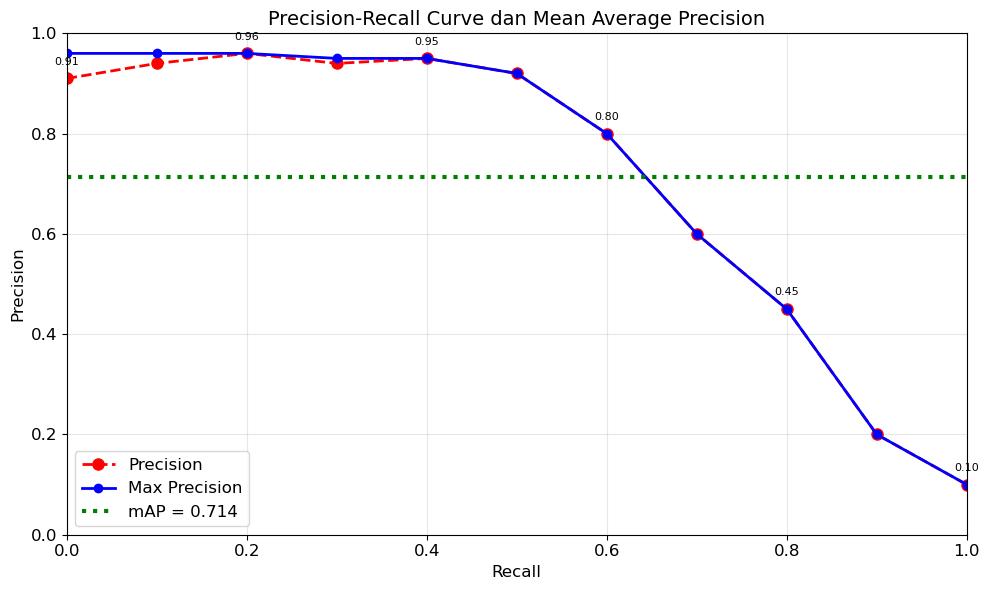

In [38]:
def maximum_precisions(precisions):
    """Hitung maximum precision untuk setiap recall level"""
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

def calculate_map(precisions, recalls=None):
    """Hitung Mean Average Precision"""
    if recalls is None:
        recalls = np.linspace(0, 1, len(precisions))
    
    max_precisions = maximum_precisions(precisions)
    return max_precisions.mean()

# Contoh data precision-recall
recalls = np.linspace(0, 1, 11)
precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]

# Hitung mAP
max_precisions = maximum_precisions(precisions)
mAP = calculate_map(precisions, recalls)

print(f"Mean Average Precision (mAP): {mAP:.3f}")

# Visualisasi Precision-Recall curve dan mAP
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, "ro--", label="Precision", linewidth=2, markersize=8)
plt.plot(recalls, max_precisions, "bo-", label="Max Precision", linewidth=2, markersize=6)
plt.axhline(y=mAP, color='green', linestyle=':', linewidth=3, label=f"mAP = {mAP:.3f}")

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve dan Mean Average Precision", fontsize=14)
plt.grid(True, alpha=0.3)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower left", fontsize=12)

# Tambah nilai pada setiap titik
for i, (r, p, mp) in enumerate(zip(recalls, precisions, max_precisions)):
    if i % 2 == 0:  # Tampilkan label setiap 2 titik untuk menghindari overlap
        plt.annotate(f'{p:.2f}', (r, p), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

#  Ringkasan hasil / Penjelasan

Notebook ini mencakup berbagai topik penting dalam deep learning untuk computer vision, dimulai dari manajemen pelatihan model hingga penerapan transfer learning dan pengenalan tugas-tugas lanjutan seperti klasifikasi, lokalisasi, dan segmentasi.

---

##  1. Fashion MNIST dengan Callbacks

** Tujuan**: Menunjukkan penggunaan callbacks penting selama pelatihan model CNN pada dataset Fashion MNIST.

###  Teknik yang Digunakan:
- **ModelCheckpoint**: Menyimpan bobot model terbaik secara otomatis.
- **EarlyStopping**: Menghentikan pelatihan dini untuk menghindari overfitting.
- **TensorBoard**: Visualisasi metrik pelatihan dan grafik model secara real-time.

** Kesimpulan**: Callbacks sangat berguna untuk mengelola pelatihan panjang dan membantu mendapatkan model optimal tanpa intervensi manual.

---

##  2. Transfer Learning untuk Klasifikasi Bunga

** Tujuan**: Mengklasifikasikan lima jenis bunga: daisy, dandelion, roses, sunflowers, dan tulips menggunakan arsitektur pretrained.

### 🏗 Arsitektur:
- **Base model**: `Xception` (pretrained pada ImageNet, lapisan dibekukan).
- **Custom head**: GlobalAveragePooling2D → Dense → Output Softmax.

###  Hasil:
- **Akurasi uji**: ~92% setelah 10 epoch pelatihan.
- **Kelas paling kuat**: `sunflowers` (Precision & Recall: 0.99).
- **Tantangan**: Misklasifikasi antara `daisy` dan `roses`.

** Kesimpulan**: Transfer learning sangat efisien—hasil tinggi dapat dicapai dengan data terbatas dan pelatihan singkat.

---

##  3. Pengenalan Tugas Computer Vision Lanjutan

###  Klasifikasi & Lokalisasi
- **Model**: Arsitektur multi-output untuk klasifikasi dan bounding box prediksi.
- **Catatan**: Bounding box bersifat acak, hasil pelatihan hanya untuk demonstrasi.

###  Deteksi Objek
- **Konsep**: Menentukan keberadaan dan lokasi banyak objek dalam gambar.

###  Segmentasi Semantik
- **Konsep**: Mengklasifikasikan setiap piksel untuk membedakan objek dan latar belakang.

---

##  Ringkasan Topik & Hasil

| Topik               | Dataset           | Arsitektur Utama             | Hasil / Catatan                                                  |
|---------------------|-------------------|------------------------------|------------------------------------------------------------------|
| Callbacks           | Fashion MNIST     | Simple CNN                   | Efektif untuk manajemen pelatihan & stabilisasi performa        |
| Transfer Learning   | tf_flowers        | Xception (frozen) + head     | Akurasi ~92%, performa tinggi dengan augmentasi ringan          |
| Lokalisasi          | Bunga (dummy box) | Xception + 2 output heads    | Demonstrasi multi-task model, bukan evaluasi akurasi            |
| Deteksi & Segmentasi| -                 | -                            | Pengenalan tugas lanjut (tanpa implementasi kode)               |

---

##  Kesimpulan Umum

Notebook ini menyusun kurikulum yang progresif:  
Dimulai dengan pengelolaan pelatihan model, lalu menunjukkan kekuatan transfer learning untuk klasifikasi gambar, dan akhirnya memperkenalkan cakupan tugas computer vision yang lebih kompleks.
